https://huggingface.co/learn/deep-rl-course/en/unit4/introduction

# Import

In [1]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Categorical
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time


# Global params

In [2]:
DEVICE = "cpu"
ROOT = os.getcwd()
ENV_NAME = 'CartPole-v1'
OUTPUT = os.path.join(ROOT, 'output', ENV_NAME)

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)


# Test env

  0%|          | 0/10 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 10/10 [00:00<00:00, 3072.08it/s]


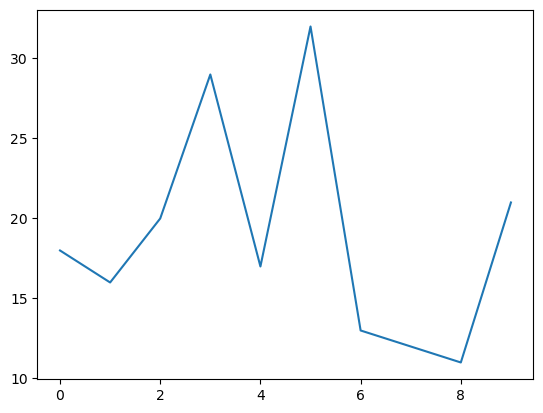

In [3]:
env = gym.make(ENV_NAME)
obs, info = env.reset()

rewards = []
for ep in tqdm(range(10)):
    obs, info = env.reset()
    total_reward = 0

    for t in count():
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated: 
            break
    
    rewards.append(total_reward)

sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.show()
env.close()

# Policy Net

In [4]:
class PolicyNet(nn.Module):

    def __init__(self, state_size, action_size, device, hidden_size = 16):
        super().__init__()
        self.device = device
        self.fc1 = nn.Linear(state_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, action_size) 
        
        self.to(device)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        return F.softmax(self.fc2(X), dim = -1)
    
    def act(self, state):
        state = torch.tensor(state).float().unsqueeze(0).to(self.device)
        probs = self(state).cpu()
        m = Categorical(probs)
        #we want to sample an action from the probability distribution over actions.
        action = m.sample()
        return action.item(), m.log_prob(action)

In [5]:
# Test model
env = gym.make(ENV_NAME)
obs, info = env.reset()
state_size = len(obs)
action_size = env.action_space.n

print('state size = ', state_size)
print('action size = ', action_size)

model = PolicyNet(state_size, action_size, device = 'cpu')

sample_state = np.random.rand(4)
print(sample_state.shape)

action, action_prob = model.act(sample_state)
print('action = ', action)
print('action prob = ', action_prob)

env.close()

state size =  4
action size =  2
(4,)
action =  0
action prob =  tensor([-0.6803], grad_fn=<SqueezeBackward1>)


In [6]:
print(np.finfo(np.float32).eps.item())

1.1920928955078125e-07


# REINFORCE algo

In [15]:
rewards = [random.randint(-10,10) for _ in range(5)]
print(rewards)

[-8, -10, 3, 5, 5]


# Return computation,

we want to calculate cummulative rewards obtained after step t, that's why we're calculating returns backwards

In [16]:
returns = deque()
gamma = 0.99

for t in reversed(range(5)):
    G_t = returns[0] if len(returns) > 0 else 0
    print(f'G_{t} = {gamma} * {G_t} + {rewards[t]}= {gamma * G_t + rewards[t]}')
    returns.appendleft(gamma * G_t + rewards[t])

print(returns)

G_4 = 0.99 * 0 + 5= 5.0
G_3 = 0.99 * 5.0 + 5= 9.95
G_2 = 0.99 * 9.95 + 3= 12.850499999999998
G_1 = 0.99 * 12.850499999999998 + -10= 2.721994999999998
G_0 = 0.99 * 2.721994999999998 + -8= -5.305224950000002
deque([-5.305224950000002, 2.721994999999998, 12.850499999999998, 9.95, 5.0])


In [17]:
def reinforce(env, policy, optimizer, training_epochs, max_t, gamma, label = 'baseline', plot_update_freq = 50):

    SAVE_PATH = os.path.join(OUTPUT, label)
    FIG_SAVE_PATH = os.path.join(SAVE_PATH, 'plot.png')
    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)

    
    scores_deque = deque(maxlen = 100)
    history = defaultdict(list)
    loop = tqdm(range(training_epochs))
    best_score = -float('inf')

    for e in loop:
        saved_log_probs = []
        rewards = []

        state, info = env.reset()

        for t in range(max_t):

            action, log_prob = policy.act(state)

            saved_log_probs.append(log_prob)
            state, reward, terminated, truncated, info = env.step(action)

            rewards.append(reward)

            if terminated or truncated:
                break
        
        scores_deque.append(sum(rewards))
        avg_reward = np.mean(scores_deque)

        history['reward'].append(avg_reward)

        returns = deque(maxlen = max_t)
        num_steps = len(rewards)

        #computing returns
        for t in reversed(range(num_steps)):
            G_t = returns[0] if len(returns) > 0 else 0
            returns.appendleft(gamma * G_t + rewards[t])

        #standardization of returns to make training more stable
        eps = np.finfo(np.float32).eps.item()
        returns = torch.tensor(returns)
        returns = (returns - returns.mean())/(returns.std() + eps)

        policy_loss = []
        for log_prob, discounted_return in zip(saved_log_probs, returns):
            #add minus because we want gradient ascend
            policy_loss.append(-log_prob * discounted_return)
        

        #should it be mean here?
        #the formula says mean right? 
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        loop.set_description(f'avg reward = {avg_reward:.2f}')

        if best_score <= avg_reward:
            best_score = avg_reward
            torch.save(model, os.path.join(SAVE_PATH, 'policy.checkpoint.torch'))
        
        if e % plot_update_freq == 0:
            plot(history, save_path=FIG_SAVE_PATH)
        
    plot(history, show=True, save_path=FIG_SAVE_PATH)
    
    return history

def plot(history, show = False, save_path = None):
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))))

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()
        
    plt.clf()
    plt.close()

state size =  4
action size =  2


  0%|          | 0/1 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  0%|          | 0/1 [00:00<?, ?it/s]

rewards =  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
G_9 = 0
G_8 = 1.0
G_7 = 2.0
G_6 = 3.0
G_5 = 4.0
G_4 = 5.0
G_3 = 6.0
G_2 = 7.0
G_1 = 8.0
G_0 = 9.0


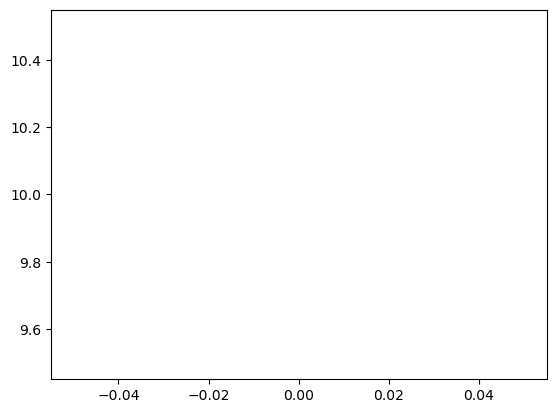

In [11]:
# training_epochs = 3000
training_epochs = 1
max_t = 1000
gamma = 1.0
lr = 0.001

env = gym.make(ENV_NAME)
obs, info = env.reset()
state_size = len(obs)
action_size = env.action_space.n
print('state size = ', state_size)
print('action size = ', action_size)

model = PolicyNet(state_size, action_size, hidden_size = 16, device = 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

reinforce(env, model, optimizer, training_epochs=training_epochs, max_t = max_t, gamma = gamma, label = 'test')

env.close()



# Evaluate

  0%|          | 0/100 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
reward = 500.00: 100%|██████████| 100/100 [00:06<00:00, 15.26it/s]


<Axes: >

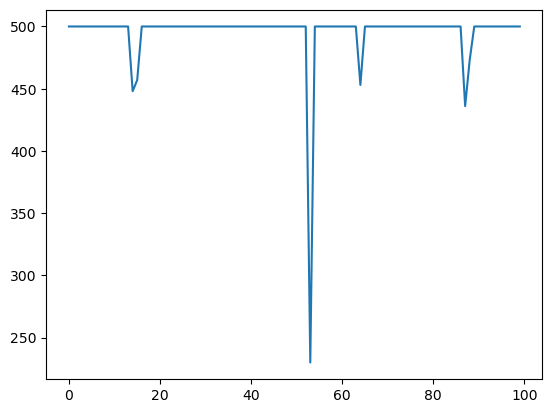

In [15]:
# nv = gym.make('CartPole-v1')
env = gym.make(ENV_NAME)
rewards = []

# net = torch.load('best_target_net.torch')
LOAD_PATH = os.path.join(OUTPUT, 'baseline', 'policy.checkpoint.torch')
eval_net = torch.load(LOAD_PATH)

loop = tqdm(range(100))
total_rewards = []

for epoch in loop:
    state, info = env.reset()
    total_reward = 0

    for t in range(max_t):

        action, log_prob = eval_net.act(state)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += 1
        if terminated or truncated:
            break
    
    total_rewards.append(total_reward)
    loop.set_description(f'reward = {total_reward:.2f}')
    
sns.lineplot(y = total_rewards, x= list(range(len(total_rewards))))